In [234]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [235]:
df = pd.read_csv('./data/cheyenne-Aug-6.csv');

df['datetime']= pd.to_datetime(df.Time, unit='s').values
df = df.sort_values(by='Time')

c = df.Time.rolling(window=2).apply(lambda x: (x[1]-x[0])>3600.0, raw=True ).fillna(0)
df['contig'] = np.cumsum(c)

cn = {v:k for v,k in enumerate(df.columns)}

df[cn[4]]  = df[cn[4]].replace(to_replace=0, value=np.nan)
df[cn[5]]  = df[cn[5]].replace(to_replace=0, value=np.nan)
df[cn[8]] = df[cn[8]].replace(to_replace=0, value=np.nan)
df[cn[9]] = df[cn[9]].replace(to_replace=0, value=np.nan)
df[cn[10]] = df[cn[10]].replace(to_replace=0, value=np.nan)
df[cn[11]] = df[cn[11]].replace(to_replace=0, value=np.nan).interpolate()
df[cn[12]] = df[cn[11]].replace(to_replace=0, value=np.nan).interpolate()
df[cn[15]] = df[cn[15]].replace(to_replace=0, value=np.nan).interpolate()
df[cn[17]] = df[cn[17]].replace(to_replace=0, value=np.nan).interpolate()
df[cn[18]] = df[cn[18]].replace(to_replace=0, value=np.nan).interpolate()
df[cn[19]] = df[cn[19]].replace(to_replace=0, value=np.nan).interpolate()

df['trip'] = (df[cn[1]]==0) 
df['trip'] = np.cumsum(df.trip.rolling(window=2,center=False).apply(lambda x: x[1]!=x[0], raw=True))

h = df.groupby(['trip','contig'])[cn[13]].rolling(window=2,center=False).apply(lambda x: x[1]-x[0], raw=True).reset_index()
h = h.rename({'level_2':'index', cn[13]:'heading_delta'},axis=1).set_index('index').drop(['trip','contig'],axis=1)
df = df.join(h)

df.trip = df.trip.fillna(0)


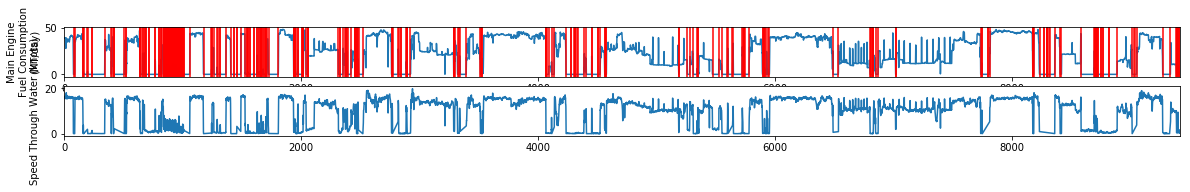

In [236]:
plt.figure(figsize=(20,2))
plt.subplot(211)
plt.plot(range(len(df.datetime)), df[cn[1]])
trips = np.cumsum(df.groupby('trip').agg({'trip':len}).values)

for t in trips:
    plt.axvline(t,c='r')
plt.ylabel('Main Engine\nFuel Consumption\n(MT/day)')
plt.xlim([0,df.shape[0]])

plt.subplot(212)
plt.plot(range(len(df.datetime)), df[cn[12]])
trips = np.cumsum(df.groupby('trip').agg({'trip':len}).values)
plt.ylabel(cn[12])
plt.xlim([0,df.shape[0]])

plt.savefig('/Users/frjo6001/Desktop/trips.pdf', format='pdf')

Data consists of two nearly contigious monitoring periords spanning 388 and 4 days respectivly. 

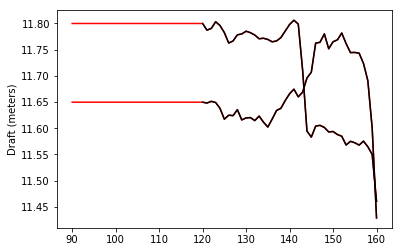

In [237]:
df[df.trip.isin([2])][cn[4]].interpolate(limit_direction='both').plot(color='r')
df[df.trip.isin([2])][cn[5]].interpolate(limit_direction='both').plot(color='r')

df[df.trip.isin([2])][cn[4]].plot(color='k')
df[df.trip.isin([2])][cn[5]].plot(color='k')
plt.ylabel('Draft (meters)')


#Fill in missing draft data for trip 2 drop trips 1 and 2
df[cn[4]] = df[cn[4]].interpolate(limit_direction='both')
df[cn[5]] = df[cn[5]].interpolate(limit_direction='both')


In [238]:
cn

{0: 'Time',
 1: 'Main Engine Fuel Consumption (MT/day)',
 2: 'Main Engine Using HFO (bool)',
 3: 'Main Engine Using MGO (bool)',
 4: 'Draft Forward (meters)',
 5: 'Draft Aft (meters)',
 6: 'Draft Mid-1 (meters)',
 7: 'Draft Mid-2 (meters)',
 8: 'Shaft Speed (RPM)',
 9: 'Shaft Torque (kNm)',
 10: 'Shaft Power (kW)',
 11: 'Speed Over Ground (knots)',
 12: 'Speed Through Water (knots)',
 13: 'Heading (degrees)',
 14: 'Rudder Angle (degrees)',
 15: 'Weather Service Apparent Wind Speed (knots)',
 16: 'Weather Service Apparent Wind Direction (degrees from bow)',
 17: 'Weather Service True Wind Speed (knots)',
 18: 'Weather Service True Wind Direction (degrees from north)',
 19: 'Weather Service Temperature (celsius)',
 20: 'Water Depth (meters)',
 21: 'datetime',
 22: 'contig'}

In [239]:
for i in range(22):
    print(i, cn[i], df2[cn[i]][df2[cn[i]]==0].shape)


0 Time (0,)
1 Main Engine Fuel Consumption (MT/day) (0,)
2 Main Engine Using HFO (bool) (459,)
3 Main Engine Using MGO (bool) (5733,)
4 Draft Forward (meters) (0,)
5 Draft Aft (meters) (0,)
6 Draft Mid-1 (meters) (29,)
7 Draft Mid-2 (meters) (0,)
8 Shaft Speed (RPM) (0,)
9 Shaft Torque (kNm) (0,)
10 Shaft Power (kW) (0,)
11 Speed Over Ground (knots) (0,)
12 Speed Through Water (knots) (0,)
13 Heading (degrees) (0,)
14 Rudder Angle (degrees) (0,)
15 Weather Service Apparent Wind Speed (knots) (0,)
16 Weather Service Apparent Wind Direction (degrees from bow) (50,)
17 Weather Service True Wind Speed (knots) (0,)
18 Weather Service True Wind Direction (degrees from north) (0,)
19 Weather Service Temperature (celsius) (0,)
20 Water Depth (meters) (4625,)
21 datetime (0,)


In [240]:
def normAngle(angle):
    if angle < -180: angle += 360
    elif angle > 180: angle -= 360
    return angle

def theLen(x): return len(x)
def totalDurr(x): return max(x) - min(x)
def active(x): return np.mean(x)>0

df.heading_delta = df.heading_delta.apply(normAngle).fillna(0)

s = df.groupby('trip').agg({cn[1]: active,
                            cn[21]: [totalDurr , theLen, min, max],
                              
                             }).rename({'min':'startTime', 'max':'endTime'},axis=1)
s.columns = s.columns.droplevel(0)
s = s.reset_index()

s = s[s.active & s.totalDurr.apply(lambda x: x.total_seconds()>3*60**2)].drop(['theLen'],axis=1)

s=s.drop('totalDurr',axis=1)

df2 = df.merge(s, on='trip', how='inner')
df2=df2[df2.trip!=0]

In [241]:
df2 = df2[(df2.datetime!=df2.startTime) & (df2.datetime!=df2.endTime)]
df2 = df2.drop(['startTime','endTime'],axis=1)

In [242]:
df2['trim'] = df2.apply(lambda x: x[cn[4]]-x[cn[5]],axis=1)
df2['rudder'] = df2[cn[14]].apply(lambda x: np.sin(np.deg2rad(x)) )
df2['depth']  = df2[cn[20]].replace(to_replace=0, value=df2[cn[20]].max())
df2['current'] = v =((df2[cn[14]].apply(normAngle) - df2[cn[14]].apply(normAngle).mean() )*((df2.heading_delta) - (df2.heading_delta).mean()))
df2['bowWind_sine'] = np.sin(np.deg2rad((df2[cn[18]]- df2[cn[13]]).apply(normAngle)))
df2['bowWind_cos'] = np.cos(np.deg2rad((df2[cn[18]]- df2[cn[13]]).apply(normAngle)))
df2['heading_delta2'] = np.sin(np.deg2rad(df2.heading_delta))
df2['wind_speed'] = df2[cn[17]]


In [243]:
from sklearn.model_selection import train_test_split
import sklearn.linear_model

lr = sklearn.linear_model.LinearRegression()
n = [cn[v] for v in range(8,11)]

D = df2[df2[n].isna().sum(1)<1][n].values
X=D[:,0:2]
y=D[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
lr.fit(X_train, y_train)
score = lr.score(X_test,y_test)
print(score)

X_unk  = df2[df2[cn[10]].isna()][[cn[8],cn[9]]].values
y_pred = lr.predict(X_unk)

df2.iloc[df2[cn[10]].isna().values, 10] = np.atleast_2d(y_pred).T



df2 = df2[df2.trip!=0]

0.9899302527020517


In [244]:
df2.to_pickle('process.pkl')

In [245]:
v =((df2[cn[14]].apply(normAngle) - df2[cn[14]].apply(normAngle).mean() )*((df2.heading_delta) - (df2.heading_delta).mean()))

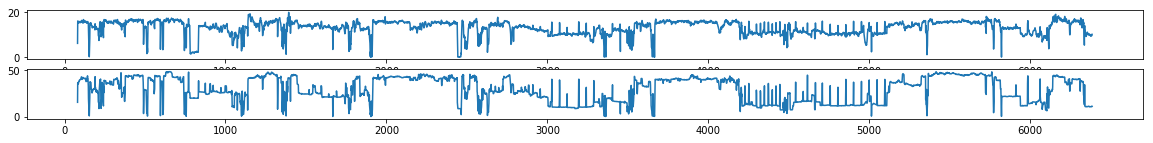

In [246]:
plt.figure(figsize=(20,2))
plt.subplot(211)
plt.plot(df2[cn[12]])
plt.subplot(212)
plt.plot(df2[cn[1]])

In [247]:
df2.columns

Index(['Time', 'Main Engine Fuel Consumption (MT/day)',
       'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)',
       'Draft Forward (meters)', 'Draft Aft (meters)', 'Draft Mid-1 (meters)',
       'Draft Mid-2 (meters)', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)', 'Speed Over Ground (knots)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service True Wind Speed (knots)',
       'Weather Service True Wind Direction (degrees from north)',
       'Weather Service Temperature (celsius)', 'Water Depth (meters)',
       'datetime', 'contig', 'trip', 'heading_delta', 'active', 'trim',
       'rudder', 'depth', 'current', 'bowWind_sine', 'bowWind_cos',
       'heading_delta2', 'wind_speed'],
      dtype='object')

In [248]:
df2[df2.trip.isin([188,238])][[cn[1],cn[10],cn[12]]].describe()

,Main Engine Fuel Consumption (MT/day),Shaft Power (kW),Speed Through Water (knots)
count,278.000000,278.000000,278.000000
mean,24.145910,4448.377642,9.975360
std,5.912359,2705.184675,5.166228
min,2.125071,5.970575,0.045732
25%,19.950360,78.177698,2.513812
50%,26.023501,5855.182311,12.848389
75%,26.725444,6012.624068,13.679389
max,38.678135,8250.057034,15.436656


In [249]:
df2[~df2.trip.isin([188,238]) & df2.active][[cn[1],cn[10],cn[12]]].describe()

,Main Engine Fuel Consumption (MT/day),Shaft Power (kW),Speed Through Water (knots)
count,5901.000000,5901.000000,5901.000000
mean,29.609719,6646.865725,13.285351
std,13.103329,3071.366355,2.805848
min,0.041610,12.036726,0.027397
25%,16.201179,3502.071732,11.216581
50%,32.739624,7424.359092,13.958135
75%,41.821361,9515.959104,15.532488
max,48.580183,10985.364886,19.844884
